In [47]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf
from finta import TA    
from config import *
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

importing necessary libraries

In [48]:
def fetch_daily_data(symbol):
    """
    Fetches daily stock data for a given symbol over the last 5 years
    @return: pandas DF containing daily stock data
    """
    today = datetime.now().strftime("%Y-%m-%d")
    five_years_ago = (datetime.strptime(today, "%Y-%m-%d") - timedelta(days=5*365)).strftime("%Y-%m-%d")
    # df = yf.download(symbol, start=five_years_ago, end=today)
    df = yf.download([symbol], '2017-01-01', '2021-12-20')

    return df

    

[*********************100%***********************]  1 of 1 completed


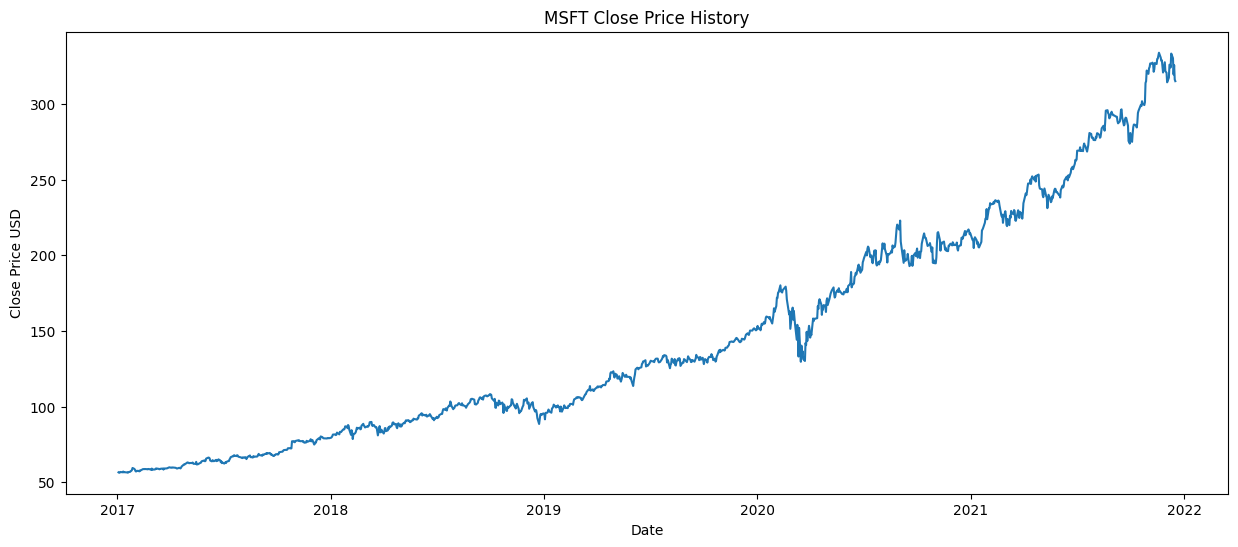

In [49]:
df = fetch_daily_data('MSFT')
df.columns = df.columns.droplevel(1) 
plt.figure(figsize=(15,6))
plt.title('MSFT Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show();

In [50]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Engineer features from stock data
    @param df: pandas DF containing stock data
    @return: pandas DF containing engineered features
    '''

    df['SMA200'] = TA.SMA(df,200) # simple moving average over 100 days
    df['RSI'] = TA.RSI(df) # Relative Strength Index
    df['ATR'] = TA.ATR(df) # Average True Range
    df['BBWIDTH'] = TA.BBWIDTH(df) # Bollinger Bands Width
    df['Williams'] = TA.WILLIAMS(df) # Williams %R

    df = df.iloc[200:, :] # drop the first 200 rows since we are using 200 day SMA 
    df['target'] = df.Close.shift(-1) # shift the closing price up one row to predict the next days closing price 
    df.dropna(inplace=True) # drop any rows with missing values
    return df

df = engineer_features(df)
df.head()

/var/folders/cp/q2ltvsgx5dd856zr339ft0z40000gn/T/ipykernel_22362/4178273622.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df.Close.shift(-1) # shift the closing price up one row to predict the next days closing price
/var/folders/cp/q2ltvsgx5dd856zr339ft0z40000gn/T/ipykernel_22362/4178273622.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True) # drop any rows with missing values


Price,Close,High,Low,Open,Volume,SMA200,RSI,ATR,BBWIDTH,Williams,target
Date,,,,,,,,,,,
2017-10-18,71.403938,71.624745,71.183132,71.459138,13300700,63.161323,72.604342,0.637448,0.081428,-6.249928,71.679947
2017-10-19,71.679947,71.698345,71.164722,71.367131,15092800,63.237983,74.322717,0.631533,0.084517,-0.473856,72.507950
2017-10-20,72.507950,72.655159,71.965133,72.057135,22866400,63.318784,78.649277,0.654532,0.090517,-3.041920,72.526375
2017-10-23,72.526375,72.995588,72.461973,72.673577,20627200,63.397234,78.735142,0.647303,0.090489,-9.058562,72.553970
2017-10-24,72.553970,72.866779,72.185955,72.590773,17517200,63.476727,78.872191,0.629559,0.088069,-10.958860,72.342369


#### Simple Moving Average - 100 day 
- Purpose: shows the overall trend over the past 100 days 
- Use in ML:
- Helps model understand if stock is long-term moving upwards or downwards


#### Relative Sitrength Index 
- Purpose: measures momentum - how strongly a stock has moved up or down recently on a 0-100 scale
- Use in ML:
- helps detect potential reversal points or trend exhaustion


#### Average True Range 
- Purpose: measures volatility - how much the price has been fluctuating
- Use in ML:
- Helps capture risk level of a stock 
- Useful for adjusting predictions based on user risk tolerance 


#### Bollinger Band Width 
- Purpose: measures the width Bollinger Bands which expand/contract based on volatility - wider = higher volatility
- Use in ML:
- can indicate a trend change



#### Williams %R
- Purpose: measures overbought/oversold conditions on scale of -100 to 0 
- Closer to 0 is overbought 
- Use in ML
- Good for identifying potential entry or exit points
- Often used with RSI to confirm signals
---
- the target column is created by shifting columns up one
- it essentially makes the next days closing price today's target

In [51]:
def train_test_split(data: pd.DataFrame,perc: float) -> tuple[np.ndarray, np.ndarray]:
    '''
    Splits data into train and test sets
    @param data: pandas DF containing stock data
    @param perc: percentage of data for test set
    @return: train set, test set
    '''

    ret = data.values
    n = int(len(data) *  (1-perc)) 
    return ret[:n], ret[n:]

In [52]:
train, test = train_test_split(df,0.2)
train

array([[ 7.14039383e+01,  7.16247448e+01,  7.11831318e+01, ...,
         8.14282738e-02, -6.24992799e+00,  7.16799469e+01],
       [ 7.16799469e+01,  7.16983445e+01,  7.11647224e+01, ...,
         8.45170180e-02, -4.73856447e-01,  7.25079498e+01],
       [ 7.25079498e+01,  7.26551588e+01,  7.19651326e+01, ...,
         9.05172668e-02, -3.04191988e+00,  7.25263748e+01],
       ...,
       [ 2.35093414e+02,  2.37437603e+02,  2.34340962e+02, ...,
         1.42128810e-01, -1.51970352e+01,  2.36118347e+02],
       [ 2.36118347e+02,  2.36224707e+02,  2.32966240e+02, ...,
         1.20640045e-01, -9.25273717e+00,  2.35721909e+02],
       [ 2.35721909e+02,  2.35857275e+02,  2.32888882e+02, ...,
         1.10200502e-01, -1.20331995e+01,  2.32995239e+02]])

In [53]:
print(len(df))
print(len(train))
print(len(test))
train[0,:-1] # first row without the last column (target)


1049
839
210


array([ 7.14039383e+01,  7.16247448e+01,  7.11831318e+01,  7.14591382e+01,
        1.33007000e+07,  6.31613228e+01,  7.26043421e+01,  6.37447983e-01,
        8.14282738e-02, -6.24992799e+00])

In [54]:
X = train[:,:-1] # all features/input variables except last column (target) - info used to predict target
y = train[:,-1] # contains only the target values (stock price trying to predict)
# overall this code separates the features and target values from the ds to train the model 
y

array([ 71.6799469 ,  72.50794983,  72.52637482,  72.55397034,
        72.34236908,  72.46198273,  77.1081543 ,  77.18177032,
        76.52854919,  76.52854919,  77.32896423,  77.41175079,
        77.71534729,  77.53136444,  77.79815674,  77.36577606,
        77.16336823,  77.21855927,  77.32896423,  76.72794342,
        76.93135834,  76.19164276,  76.31182861,  77.41217041,
        76.84814453,  76.98684692,  77.55089569,  78.48478699,
        77.06079865,  77.82826996,  77.91149139,  74.97108459,
        75.44268036,  76.5430069 ,  76.27485657,  77.81904602,
        78.80841827,  79.1320343 ,  78.9193573 ,  78.30910492,
        80.30635071,  79.87174988,  79.36319733,  79.07656097,
        79.05806732,  79.06731415,  78.9655838 ,  79.25224304,
        79.26150513,  79.09507751,  79.47416687,  79.84402466,
        80.54676819,  81.54537964,  81.62861633,  81.57311249,
        81.2032547 ,  81.44366455,  82.8491745 ,  81.69334412,
        83.3484726 ,  83.31147766,  83.21901703,  84.70

In [55]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


params = {
    'max_depth': [3,6], # determines the max depth of each tree in the model 
    'learning_rate': [0.05], # controls the step size in each boosting iteration which prevents overfitting
    'n_estimators': [700,1000], # number of trees in the model
    'colsample_bytree': [0.3, 0.7], # determines the fraction of features to randomly sample for each tree 
}

# XGBoost Regressor is a type of gradient boosting model that build trees one at a time, each tree is trained
# to correct the errors of the previous tree by focusing on the examples that were misclassified 
# the model then combines the predictions of all trees to make a final prediction
# gradient boosting is a technique that build an ensemble of weak models to create a strong predictive model
xgbr = XGBRegressor(seed = 20) # initalize the model 


# GridSearchCV is used to find the best parameters for the model by searching through a grid of parameters
# take xgbr model, params, neg_mean_sqaured error as the scoring metric, verbose = 1 for detailed output
# the xgbr model works by building trees one at a time, each tree is trained to correct the errors of the previous tree by focusing on the examples that were misclassified
# the learning rate controls how much each tree can correct the errors of the previous tree
# the max depth controls the complexity of each tree 
# the colsample_bytree controls the fraction of features to randomly sample for each tree
# this helps prevent overfitting by forcing the model to consider different combinations of features 
# the n_estimators controls the number of trees in the model which also helps prevent overfitting 
# the scoring is neg_mean_squared_error which is the average of the squared differences between the predicted and actual values
# this metric penalizes large errors more heavily which helps the model focus on minimizing large errors
# the verbose works to print the best parameters and the lowest RMSE 
modl = GridSearchCV(estimator=xgbr, param_grid=params, scoring = 'neg_mean_squared_error', verbose=1)
modl.fit(X, y) # fit the model 


print('Best Parameters:', modl.best_params_)
print('Lowest RMSE:', (-modl.best_score_)**(1/2.0))
# the model.best_params_ is the best parameters found by grid search
# best parameters are the ones that result in the lowest RMSE 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Lowest RMSE: 13.174612613988838


In [56]:
# this is the model that will be used to make predictions
# the objective is to minimize the error between the predicted and actual values
# reg means regression and squarederror is the loss function 
# gamma is the minimum loss reduction required to make a further partition on a leaf node of the tree
model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000, colsample_bytree = 0.7, learning_rate = 0.05, max_depth = 3, gamma = 1)
model.fit(X,y) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
test[0,:] # this accesses the first row of the test set 

array([ 2.32995239e+02,  2.35789596e+02,  2.32231376e+02,  2.35683236e+02,
        2.52626000e+07,  2.02870524e+02,  6.04929664e+01,  3.87209752e+00,
        9.59305342e-02, -3.36130876e+01,  2.26749039e+02])

In [58]:
val = np.array(test[0,:-1]).reshape(1,-1) # this line converts the first row of the test set into a numpy array and reshapes it into a 1x-1 array 
pred = model.predict(val) # this line uses the model to make a prediction on the first row of the test set 
pred

# first it takes the first row of the test data and removes the last column (target)
# then it reshapes the resulting array into a 2D array with 1 row 
# this array represents the features of stock data for a particular day
# next it uses the trained model to make a prediction on this day's features 
# the predict function takes the reshaped array and returns the predicted value 

array([231.6178], dtype=float32)

In [59]:
def xgb_predict(train: pd.DataFrame, val: pd.DataFrame) -> float:
    '''
    # Predicts closing price of stockusing XGBoost Regressor 
    @param train: pandas DF containing training data 
    @param val: pandas DF as a validation set 
    @return: float prediction

    ---
    - First the training data is converted to a numpy array 
    - Then the features and target values are separated 
    - Then the model is initialized and trained on the training data 
    - Then the validation set is converted to a numpy array and reshaped into a 2D array with 1 row
    - Then the model is used to make a prediction on the validation set 
    - The prediction is then returned as a float
    '''
    train = np.array(train)
    X, y = train[:,:-1], train[:,-1]
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000, learning_rate = 0.05, colsample_bytree = 0.7, max_depth =3, gamma = 1)
    model.fit(X,y)
    val = np.array(val).reshape(1,-1)
    pred = model.predict(val)
    return pred[0]

In [61]:
# using the xgb_predict function 
# passing in the training data and the first row of the test data 
# the goal is to used the trained model to predict the closing price of the stock for the first row of the test data 
xgb_predict(train, test[0, :-1])


231.6178

In [62]:
def mape(actual, pred) -> float:
    ''' 
    Calculates the mean absolute percentage error between the actual and predicted values 
    @param actual: array containing actual values 
    @param pred: array containing predicted values
    @return: float mape
    '''
    actual = np.array(actual)
    pred = np.array(pred)
    mape = np.mean(np.abs((actual - pred) / actual) * 100)
    return mape 


In [72]:
from sklearn.metrics import root_mean_squared_error

def validate(data, perc):
    '''
    Validates the model by predicting the closing price of the stock for each day in the test set 
    @param data: df containing stock data 
    @para perc: percentage of data for test set 
    @return: float error, float MAPE, array of actual targetvalues, array of predicted values
    '''
    predictions = []
    train, test = train_test_split(data, perc)
    # data is split into training and testing sets 
    history = [x for x in train] # history is a list of the elements in the training set 


    # for loop iterates over each element in the testing set 
    # for each iteration, the input features (X_test) and target value (y_test) are extracted from the test set 
    # the xgb_predict function is then called to predict the target value using the history the history data 
    # the predicted value is then added to the predictions list  
    for i in range(len(test)):
        X_test, y_test = test[i,:-1], test[i,-1]
        pred = xgb_predict(history, X_test)
        predictions.append(pred)

        history.append(test[i])

    # the mean squared error is calculated between the actual target values and predicted values 
    error = root_mean_squared_error(test[:,-1], predictions)

    # the mape is calculated between the actual and predicted values 
    MAPE = mape(test[:,-1], predictions)


    return error, MAPE, test[:,-1], predictions

In [71]:
rmse, MAPE, y, pred = validate(df, 0.2)

/Users/usmansheikh/Documents/CS499/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [73]:
print("RMSE:", f'{rmse}')
print("MAPE:", f'{MAPE}')
print(y)
print(pred)

RMSE: 4.4867315921145625
MAPE: 1.285156132814478
[226.7490387  225.5500946  226.78770447 221.41171265 224.68952942
 229.09861755 226.13018799 220.02902222 219.22650146 223.93539429
 219.8646698  226.04321289 224.72821045 229.28233337 227.94796753
 227.03912354 229.84312439 229.1953125  223.08444214 222.72673035
 228.18003845 229.71740723 227.66758728 224.65084839 228.65385437
 227.45489502 224.17706299 227.96734619 234.3296051  240.8271637
 239.65719604 241.62971497 244.86883545 247.38282776 247.44081116
 249.93544006 247.13145447 250.9119873  252.11097717 250.1771698
 249.71308899 251.95626831 248.65913391 252.50746155 252.8941803
 253.30024719 246.13549805 244.15333557 243.83425903 243.52482605
 239.58955383 238.3132019  241.46531677 244.10501099 238.99975586
 238.08113098 231.0904541  234.98706055 239.93763733 237.06591797
 235.03541565 235.61689758 238.87319946 237.60365295 243.04051208
 243.95146179 243.72857666 241.61587524 241.97442627 239.76481628
 239.66790771 238.12698364 243

In [74]:
# takes the predicted values from the model and converts them into a numpy array
pred = np.array(pred)

# then it combines these predicted values with the actual target values from the test set 
# the numpy.c_ function allows us to see the predicted values alongside the actual target values
test_pred = np.c_[test, pred]

In [79]:
df_TP = pd.DataFrame(test_pred, columns = ["Close",	"High",	"Low",	"Open",	"Volume",	"SMA200" ,"RSI",	"ATR",	"BBWIDTH",	"Williams",	"Target", "Pred"])

Text(0, 0.5, 'Price USD')

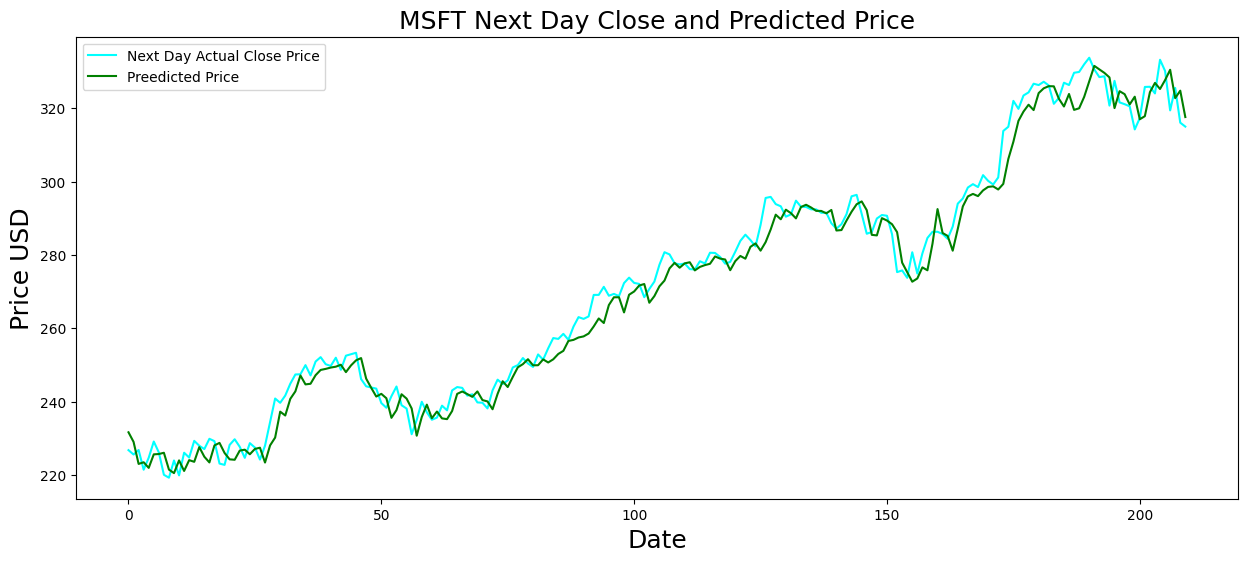

In [83]:
plt.figure(figsize = (15,6))
plt.title("MSFT Next Day Close and Predicted Price", fontsize = 18)
plt.plot(df_TP['Target'], label = 'Next Day Actual Close Price', color = 'cyan')
plt.plot(df_TP['Pred'], label = 'Predicted Price', color = 'green', alpha = 1)
plt.xlabel('Date', fontsize = 18)
plt.legend(loc = 'upper left')
plt.ylabel('Price USD', fontsize = 18)

In [84]:
df_TP

,Close,High,Low,Open,Volume,SMA200,RSI,ATR,BBWIDTH,Williams,Target,Pred
0,232.995239,235.789596,232.231376,235.683236,25262600.0,202.870524,60.492966,3.872098,0.095931,-33.613088,226.749039,231.617798
1,226.749039,230.055854,224.708867,229.562738,36446900.0,203.130652,48.521098,3.737713,0.081861,-83.971924,225.550095,229.011749
2,225.550095,227.058465,221.160335,222.707390,30228700.0,203.379713,46.614135,3.909569,0.075074,-73.031347,226.787704,222.990906
3,226.787704,227.416187,221.421376,222.397945,26339700.0,203.629792,48.848921,3.936048,0.071420,-65.428046,221.411713,223.442612
4,221.411713,226.826375,220.338447,224.399447,39542200.0,203.843133,40.849539,4.201710,0.077475,-93.723282,224.689529,221.912094
...,...,...,...,...,...,...,...,...,...,...,...,...
205,333.212677,333.660143,325.673709,325.858537,38095700.0,271.931195,62.377057,8.035086,0.065072,-22.534607,330.158203,327.667480
206,330.158203,334.428679,329.846910,331.403348,28899400.0,272.436492,58.510411,7.659180,0.066036,-17.041951,319.399353,330.479767
207,319.399353,325.527823,315.284525,324.146476,44438700.0,272.902838,47.371541,8.285930,0.068580,-59.976701,325.537476,322.746918
208,325.537476,326.062780,315.663866,319.661936,35381100.0,273.430381,52.882698,8.733405,0.067670,-35.481633,316.052979,324.784882


In [85]:
df.tail()

Price,Close,High,Low,Open,Volume,SMA200,RSI,ATR,BBWIDTH,Williams,target
Date,,,,,,,,,,,
2021-12-10,333.212677,333.660143,325.673709,325.858537,38095700,271.931195,62.377057,8.035086,0.065072,-22.534607,330.158203
2021-12-13,330.158203,334.428679,329.846910,331.403348,28899400,272.436492,58.510411,7.659180,0.066036,-17.041951,319.399353
2021-12-14,319.399353,325.527823,315.284525,324.146476,44438700,272.902838,47.371541,8.285930,0.068580,-59.976701,325.537476
2021-12-15,325.537476,326.062780,315.663866,319.661936,35381100,273.430381,52.882698,8.733405,0.067670,-35.481633,316.052979
2021-12-16,316.052979,327.590047,314.224166,326.568620,35034800,273.914513,45.035101,9.006477,0.071303,-73.330893,314.982941
